In order to use this notebook you can use the example-data file provided as "newData_part.csv" with this repository. It is due to github restrictions, half the data we used for our experiments. If you want to use the whole data set, feel free to download them at 

https://drive.google.com/file/d/1XI0oJ3Tnnr3DHiCe0oD52nt7FIbinRs_/view?usp=sharing 


### Colab Setup

In [ ]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/PMSM_Transformer_Observer"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
  !pwd

In [ ]:
# import matlab.engine

# matlabEngine = matlab.engine.start_matlab('-nodesktop')

# # Generate code
# matlabEngine.rtwbuild()

 # Switch to the directory on the Google Drive that you want to use
 import os
 drive_root = mount + "/My Drive/Transformers2022"
  
 # Create drive_root if it doesn't exist
 create_drive_root = True
 if create_drive_root:
   print("\nColab: making sure ", drive_root, " exists.")
   os.makedirs(drive_root, exist_ok=True)
  
# Change to the directory
print("\nColab: Changing directory to ", drive_root)
%cd $drive_root
!pwd

### Import Essential Libraries

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import seaborn as sns
from pathlib import Path
import shutil

### Import essential Tensorflow - Keras libraries

In [ ]:
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta,Adagrad,Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.utils import plot_model, to_categorical, normalize
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


### Check for available GPUs and configure Tensorflow session to utilize GPU

In [ ]:
# try:
#   # tf.debugging.experimental.enable_dump_debug_info('.', tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)
#   # tf.debugging.set_log_device_placement(True)
#   from tensorflow.python.client import device_lib

#   device_name = tf.test.gpu_device_name()
#   if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
#   print('Found GPU at: {}'.format(device_name))

#   config = tf.compat.v1.ConfigProto()
#   config.gpu_options.allow_growth = True
#   config.gpu_options.per_process_gpu_memory_fraction = 0.1
#   sess = tf.compat.v1.InteractiveSession(config=config)
#   set_session(sess)
#   print(device_lib.list_local_devices())
#   gpus = tf.config.experimental.list_physical_devices('GPU')
#   for gpu in gpus:
#     try:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       # Restrict TensorFlow to only use the first GPU
#       tf.config.set_visible_devices(gpus[0], 'GPU')
#       logical_gpus = tf.config.list_logical_devices('GPU')
#       print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#       # Visible devices must be set before GPUs have been initialized
#       print(e)

# except Exception as error:
#     print("Error trying to configure computing device.")
#     print(error)

### Version Check: Tensorflow - Cuda - CuDNN 

In [ ]:
from tensorflow.python.platform import build_info as tf_build_info
print("Tensorflow verison: ",tf.__version__)
print("CUDA verison: ", tf_build_info.build_info['cuda_version'])
print("CUDNN verison: ", tf_build_info.build_info['cudnn_version'])

Tensorflow verison:  2.9.1
CUDA verison:  64_112
CUDNN verison:  64_8


### Setup Tensorflow-GPU precision 
Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory. 

In [ ]:
# tf.keras.backend.floatx()
# tf.keras.backend.set_floatx('float16')
# tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
tf.keras.backend.floatx()


'float32'

### Import CSV Data with Pandas

In [ ]:
# file=r'newData.csv'
# file=r'newData_old.csv'
file=r'PMSM_Data_5kHz.csv'
# file=r'PMSM_Data_10kHz.csv'

myData = pd.read_csv(file, delimiter=',')# usecols = ['Va', ' Vb', ' Vc', ' Ia', ' Ib ', ' Ic ', ' dIa ', ' dIb ',' dIc ', ' dOmega_elec', ' Ia_', ' Ib_ ', ' Ic_ ', ' Te', ' Omega_elec', ' cTheta_elec', ' sTheta_elec'])
# myData.round(decimals=6)
# myData=myData.astype(np.float32)
# myData=myData.astype(np.float16)
myData.describe()

,Time,Va,Vb,Vc,Id,Iq,I0,dIa,dIb,dIc,...,Theta_elec,cTheta_elec,sTheta_elec,Tload,Flux_a,Flux_b,Flux_c,Flux_d,Flux_q,Flux_0
count,500001.0000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,...,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000
mean,50.0000,2.522340,-1.335646,-1.186704,-281.585946,65.376383,-0.000003,-0.000003,-0.000012,0.000015,...,3.146570,-0.031661,0.022060,-3.390611,0.017263,-0.007008,0.013855,0.004904,-15.695293,0.013919
std,28.8676,275.218004,275.345053,274.957917,180.279422,63.500330,0.013689,0.243099,0.247393,0.248703,...,1.818344,0.708948,0.704205,70.446190,164.832326,164.620584,164.600071,0.055663,284.809523,0.079340
min,0.0000,-420.000000,-420.000000,-420.000000,-514.070000,-253.800000,-0.263410,-2.894700,-3.042400,-2.976000,...,0.000000,-1.000000,-1.000000,-120.000000,-724.810000,-724.360000,-745.990000,-1.159200,-962.920000,-2.131800
25%,25.0000,-269.720000,-273.210000,-272.730000,-414.330000,15.397000,-0.005417,-0.159510,-0.155000,-0.154930,...,1.549900,-0.752190,-0.676470,-57.723000,-93.483000,-87.262000,-90.701000,-0.008380,-220.780000,-0.010470
50%,50.0000,7.617300,-1.624600,-0.198130,-339.280000,55.987000,0.000016,-0.002612,0.002889,-0.002658,...,3.126800,-0.035965,0.034407,-6.357800,-1.027500,0.484530,-1.765500,0.000194,-3.832500,0.001924
75%,75.0000,273.220000,269.890000,268.650000,-183.560000,107.380000,0.005573,0.157720,0.160620,0.154890,...,4.766000,0.667440,0.727500,49.363000,93.839000,92.830000,93.855000,0.012646,198.470000,0.028406
max,100.0000,420.000000,420.000000,420.000000,487.170000,552.210000,0.123710,3.092700,3.076200,3.244600,...,6.283200,1.000000,1.000000,120.000000,785.950000,712.970000,733.620000,2.461800,893.780000,3.046300


### Check Datatypes

In [ ]:
# myData.convert_dtypes('float16')
myData.dtypes

Time           float64
Va             float64
Vb             float64
Vc             float64
Id             float64
Iq             float64
I0             float64
dIa            float64
dIb            float64
dIc            float64
dOmega_elec    float64
Ia             float64
Ib             float64
Ic             float64
Te             float64
Omega_elec     float64
Theta_elec     float64
cTheta_elec    float64
sTheta_elec    float64
Tload          float64
Flux_a         float64
Flux_b         float64
Flux_c         float64
Flux_d         float64
Flux_q         float64
Flux_0         float64
dtype: object

### Check Shape of DataFrame

In [ ]:
myData.shape

(500001, 26)

### List of features or signals used in the data-set.

In [ ]:
#Va,Vb,Vc,Ia,Ib,Ic,dIa,dIb,dIc,dOmega_elec,Ia_,Ib_,Ic_,Te,Omega_elec,cTheta_elec,sTheta_elec
data_top = myData.columns.values
data_top

array(['Time', 'Va', 'Vb', 'Vc', 'Id', 'Iq', 'I0', 'dIa', 'dIb', 'dIc',
       'dOmega_elec', 'Ia', 'Ib', 'Ic', 'Te', 'Omega_elec', 'Theta_elec',
       'cTheta_elec', 'sTheta_elec', 'Tload', 'Flux_a', 'Flux_b',
       'Flux_c', 'Flux_d', 'Flux_q', 'Flux_0'], dtype=object)

### Display top rows of the DataFrame

In [ ]:
myData.head()

,Time,Va,Vb,Vc,Id,Iq,I0,dIa,dIb,dIc,...,Theta_elec,cTheta_elec,sTheta_elec,Tload,Flux_a,Flux_b,Flux_c,Flux_d,Flux_q,Flux_0
0,0.0000,0.00000,-363.73,363.73,0.000000,0.000,0.000000e+00,0.000000,0.00000,0.00000,...,0.000000,1.00000,0.000000,1.04,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000
1,0.0002,0.00000,-363.73,363.73,-0.009479,-42.788,8.129600e-08,-0.000003,-1.44090,1.44090,...,0.000074,1.00000,0.000221,1.58,0.000975,-3.9028,3.9018,-0.000013,-5.5187,-0.000020
2,0.0004,0.00000,-363.73,363.73,-0.153950,-81.094,6.373700e-06,-0.000124,-1.27320,1.27340,...,0.000628,1.00000,0.001885,2.12,0.033108,-15.5750,15.5410,-0.000455,-22.0030,-0.000673
3,0.0006,0.89064,-364.18,363.28,-0.695050,-114.430,6.924600e-05,0.002774,-1.09230,1.08960,...,0.002125,0.99998,0.006373,3.20,0.245410,-34.1900,33.9360,-0.003151,-48.1730,-0.004669
4,0.0008,0.89064,-364.18,363.28,-2.053900,-142.440,3.527700e-04,-0.000422,-0.89897,0.89943,...,0.004963,0.99989,0.014888,3.74,0.985340,-58.9310,57.9160,-0.011461,-82.6320,-0.016961


### Display bottom rows of the DataFrame

In [ ]:
myData.tail()

,Time,Va,Vb,Vc,Id,Iq,I0,dIa,dIb,dIc,...,Theta_elec,cTheta_elec,sTheta_elec,Tload,Flux_a,Flux_b,Flux_c,Flux_d,Flux_q,Flux_0
499996,99.999,-303.89,1.5645,302.32,-202.07,23.683,-0.005890,-0.32499,0.18872,0.13637,...,2.6395,-0.064553,0.99791,-22.377,-220.79,98.014,122.760,-0.006487,270.97,-0.009796
499997,99.999,-303.89,1.5645,302.32,-202.30,24.039,-0.004753,-0.30182,0.14603,0.15588,...,2.6275,-0.028593,0.99959,-22.377,-219.83,104.450,115.350,-0.006012,269.34,-0.013237
499998,100.000,-318.40,33.3400,285.06,-202.17,24.687,-0.003465,-0.34283,0.24108,0.10188,...,2.6156,0.007179,0.99997,-22.377,-218.49,110.590,107.880,-0.007620,267.60,-0.012548
499999,100.000,-318.40,33.3400,285.06,-201.81,25.644,-0.002045,-0.32036,0.19614,0.12433,...,2.6037,0.042719,0.99909,-22.377,-217.01,116.520,100.470,-0.008601,266.02,-0.014482
500000,100.000,-396.34,77.8080,318.53,-202.63,26.105,-0.001016,-0.30070,0.15590,0.14486,...,2.5920,0.078001,0.99695,-22.377,-215.30,122.240,93.064,-0.003004,264.49,0.000322


### Downsample to 1kHz

In [ ]:
print("Data Type:", type(myData.values))
print("Data Dtype:", myData.values.dtype)
print("Data Shape:", myData.values.shape)
print("Data Infinite values:", np.isinf(myData.values).any())
print("Data NaN values:", np.isnan(myData.values).any())

Data Type: <class 'numpy.ndarray'>
Data Dtype: float64
Data Shape: (500001, 26)
Data Infinite values: False
Data NaN values: False


In [ ]:
# samplePeriod = myData['Time'][2] - myData['Time'][1]
# sampleFrequency = 1/samplePeriod
# print(f'Old Sample Period: {(samplePeriod*1000).round(2)} ms')
# print(f'Old Sample Frequency: {(sampleFrequency/1000).round(2)} kHz')
time = myData['Time']
time = pd.to_timedelta(time, unit='T')
# myData = myData.set_index(time).resample('0.001T').last().reset_index(drop=True)
# myData.to_csv(r'downsampledData.csv')
# myData = pd.read_csv(r'downsampledData.csv', delimiter=',')
samplePeriod = myData['Time'][2] - myData['Time'][1]
sampleFrequency = 1/samplePeriod
myData = myData.drop(columns=['Time'])
print(f'New Sample Period: {(samplePeriod*1000).round(2)} ms')
print(f'New Sample Frequency: {(sampleFrequency/1000).round(2)} kHz')

New Sample Period: 0.2 ms
New Sample Frequency: 5.0 kHz


In [ ]:
print("Data Type:", type(myData.values))
print("Data Dtype:", myData.values.dtype)
print("Data Shape:", myData.values.shape)
print("Data Infinite values:", np.isinf(myData.values).any())
print("Data NaN values:", np.isnan(myData.values).any())

Data Type: <class 'numpy.ndarray'>
Data Dtype: float64
Data Shape: (500001, 25)
Data Infinite values: False
Data NaN values: False


### Check for Missing Data 


<Figure size 2160x5760 with 0 Axes>

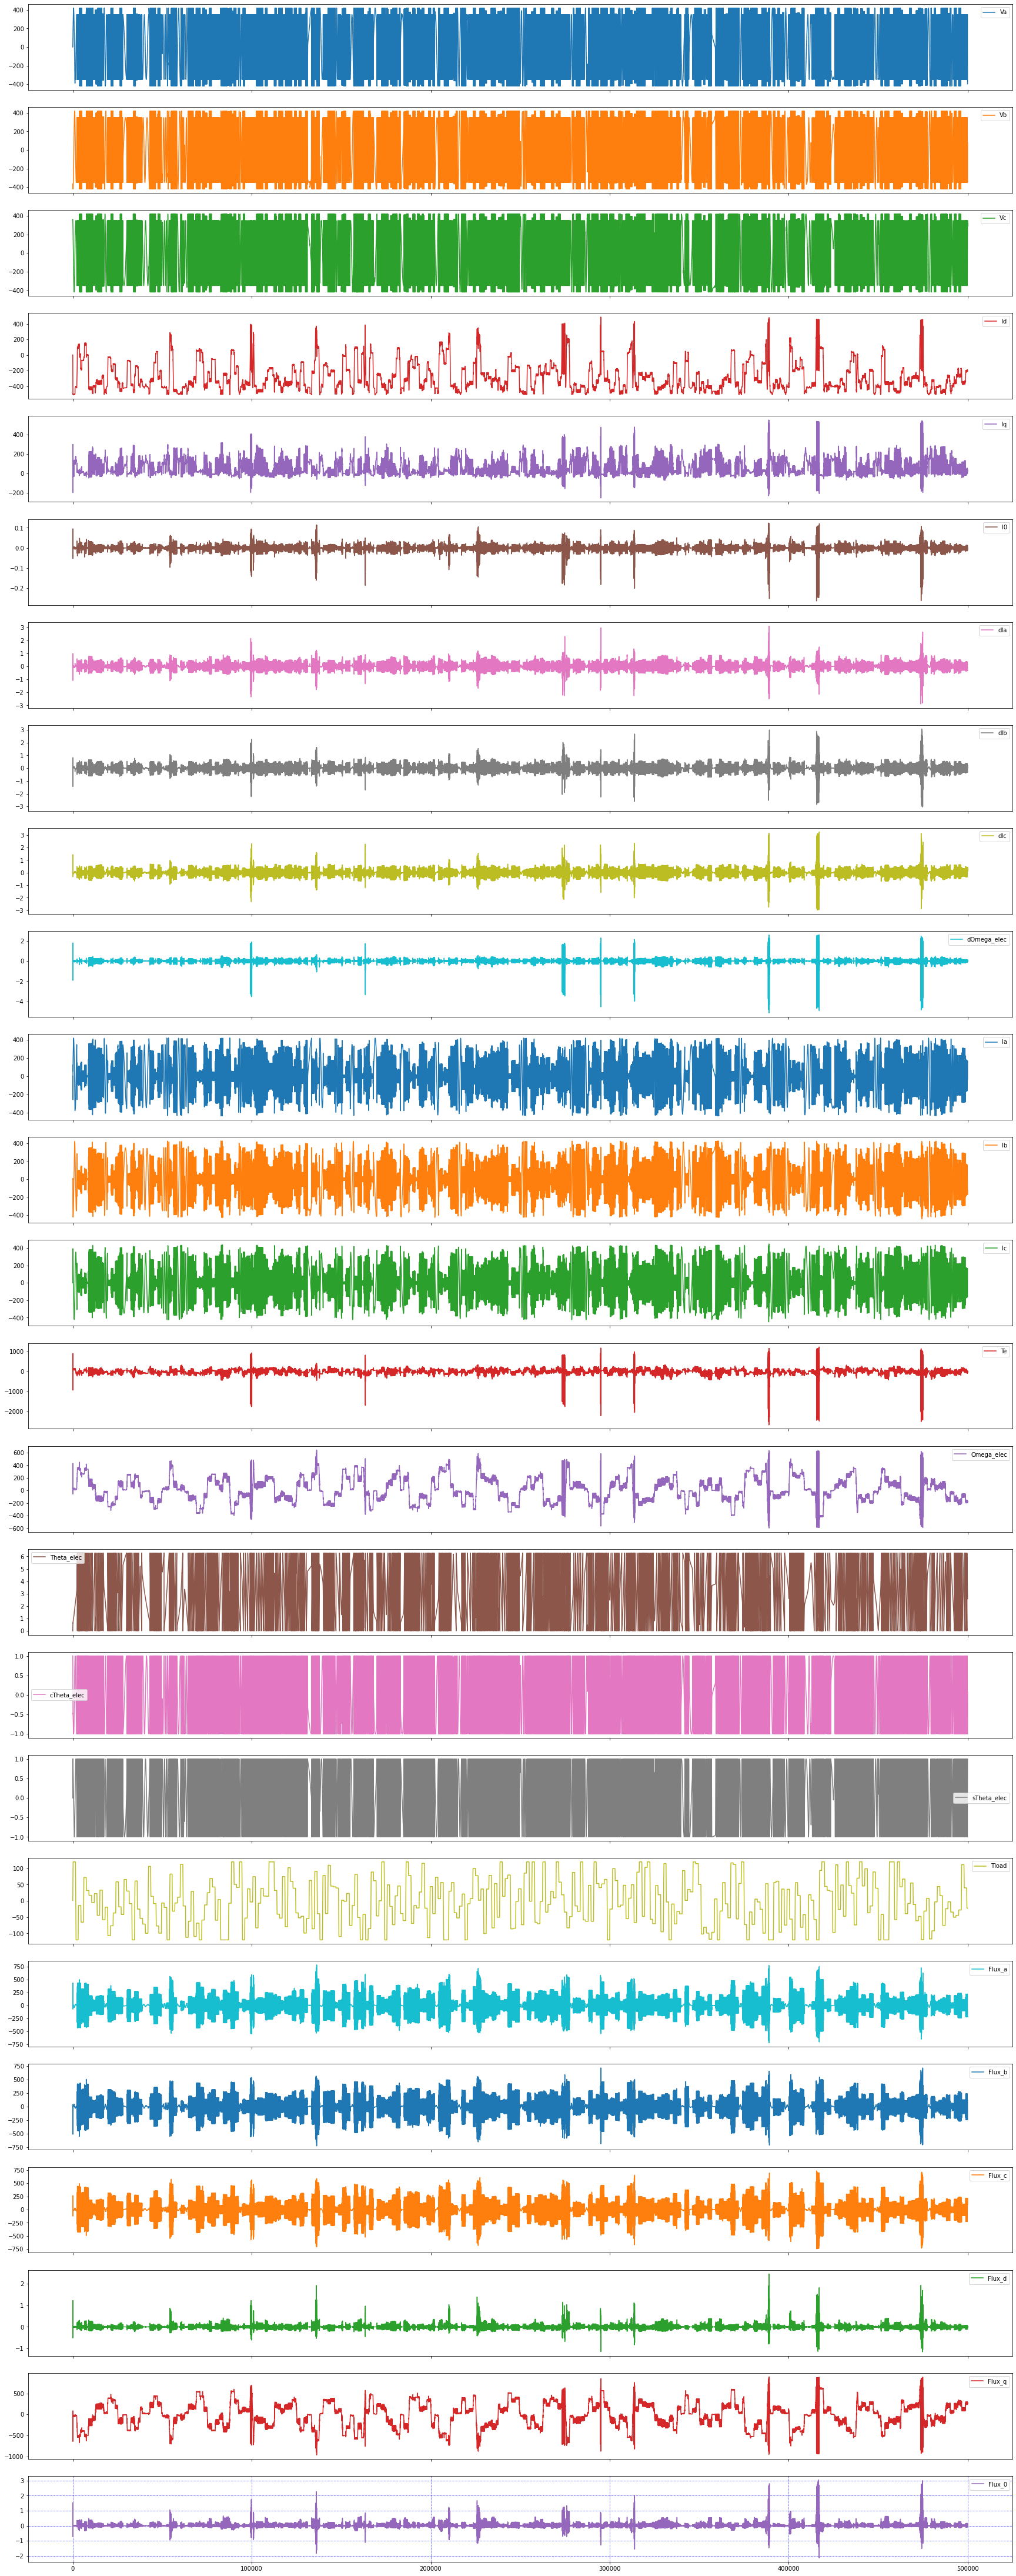

False

In [ ]:
myData['Te'].clip(-1000,1000)
plt.figure(figsize=(30, 5*16))
myData.plot(subplots=True, figsize=(30, 5*16))
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.show()
myData.isnull().values.any()

### Plot Motor Operation Modes

C:\Users\adamo\AppData\Local\Temp\ipykernel_14380\4066705790.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


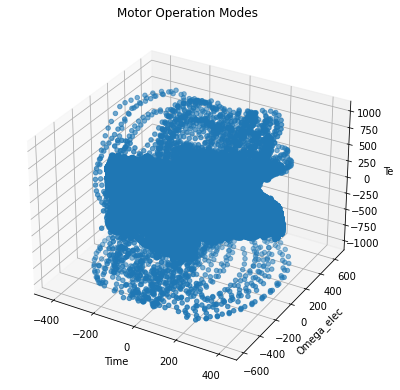

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig)

x = myData['Ia']
y = myData['Omega_elec']
z = myData['Te'].clip(-1000,1000)

c = ['grp']
cb = ax.scatter(x,y,z, c=None, cmap='coolwarm', label=['Time','Omega_elec','Te'])
ax.set_xlabel('Time')
ax.set_ylabel('Omega_elec')
ax.set_zlabel('Te')
plt.title('Motor Operation Modes')
# ax.legend(['Te','Omega_elec','dOmega_elec'])
plt.grid(color='r', linestyle='-.', linewidth=0.5)
# plt.colorbar(cb)

### Plot Motor Operation Modes

C:\Users\adamo\AppData\Roaming\Python\Python39\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


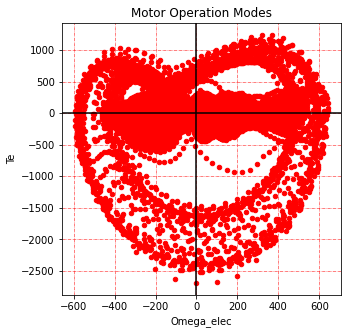

In [ ]:
from matplotlib import cm

cmap = cm.get_cmap('jet')
colors = cm.jet(np.linspace(-600, 600, 1))

myData.plot.scatter(x='Omega_elec', y='Te', color='red', cmap=cmap, figsize=(5,5))
# plt.scatter(myData['Omega_elec'], myData['Te'], s=120, cmap=cmap, edgecolor='None')
plt.axvline(x=0, c="black", label="Omega_elec")
plt.axhline(y=0, c="black", label="Te")
plt.title('Motor Operation Modes')
# myData.plot.scatter(x = 'Omega_elec', y = 'Te', c = 'red', figsize=(20,20))
plt.grid(color='r', linestyle='-.', linewidth=0.5)
plt.show()

### Plot a few signals 


plt.figure(figsize=(25,5))
myData['Te'][1000:100000].plot(legend=True)
plt.grid(color='r', linestyle='-.', linewidth=0.5)
plt.show()

plt.figure(figsize=(25,5))
myData['Omega_elec'][1000:100000].plot(legend=True)
plt.grid(color='y', linestyle='-.', linewidth=0.5)
plt.show()

plt.figure(figsize=(25,5))
myData['Theta_elec'][0:10000].plot(legend=True)
plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.show()

### Input - Output Feature Selection

In [ ]:
input_names = ['Va','Vb','Vc','Ia','Ib','Ic'] #'dOmega_elec','dIa','dIb','dIc'
target_names = ['Id','Iq', 'I0','Te','Omega_elec','cTheta_elec','sTheta_elec','Tload','Flux_d','Flux_q','Flux_0','Theta_elec'] 

### Attempting to Predict the future Target Features.

#### To achieve this we shift the target features by one timestep backward

In [ ]:
shift_steps = 1

### Create a new DataFrame with the time-shifted data.

#### **Note the negative time-shift!**

In [ ]:
df_targets = myData[target_names].shift(-shift_steps)
df_targets

,Id,Iq,I0,Te,Omega_elec,cTheta_elec,sTheta_elec,Tload,Flux_d,Flux_q,Flux_0,Theta_elec
0,-0.009479,-42.788,8.129600e-08,192.6800,3.6766,1.000000,0.000221,1.580,-0.000013,-5.5187,-0.000020,0.000074
1,-0.153950,-81.094,6.373700e-06,365.1800,14.6580,1.000000,0.001885,2.120,-0.000455,-22.0030,-0.000673,0.000628
2,-0.695050,-114.430,6.924600e-05,515.2900,32.0930,0.999980,0.006373,3.200,-0.003151,-48.1730,-0.004669,0.002125
3,-2.053900,-142.440,3.527700e-04,641.5100,55.0490,0.999890,0.014888,3.740,-0.011461,-82.6320,-0.016961,0.004963
4,-4.720400,-164.910,1.159300e-03,743.0700,82.5590,0.999600,0.028441,4.280,-0.027882,-123.9300,-0.041105,0.009482
...,...,...,...,...,...,...,...,...,...,...,...,...
499996,-202.300000,24.039,-4.752900e-03,5.7244,-179.4300,-0.028593,0.999590,-22.377,-0.006012,269.3400,-0.013237,2.627500
499997,-202.170000,24.687,-3.464600e-03,5.1993,-178.2700,0.007179,0.999970,-22.377,-0.007620,267.6000,-0.012548,2.615600
499998,-201.810000,25.644,-2.044800e-03,2.6660,-177.2200,0.042719,0.999090,-22.377,-0.008601,266.0200,-0.014482,2.603700
499999,-202.630000,26.105,-1.016100e-03,3.4234,-176.2100,0.078001,0.996950,-22.377,-0.003004,264.4900,0.000322,2.592000


**WARNING!** You should double-check that you have shifted the data in the right direction! We want to predict the future, not the past!

The shifted data-frame is confusing because Pandas keeps the original time-stamps even though we have shifted the data. You can check the time-shift is correct by comparing the original and time-shifted data-frames.

This is the first `shift_steps + 5` rows of the original data-frame:

In [ ]:
myData[target_names].head(shift_steps + 5)

,Id,Iq,I0,Te,Omega_elec,cTheta_elec,sTheta_elec,Tload,Flux_d,Flux_q,Flux_0,Theta_elec
0,0.000000,0.000,0.000000e+00,0.00,0.0000,1.00000,0.000000,1.04,0.000000,0.0000,0.000000,0.000000
1,-0.009479,-42.788,8.129600e-08,192.68,3.6766,1.00000,0.000221,1.58,-0.000013,-5.5187,-0.000020,0.000074
2,-0.153950,-81.094,6.373700e-06,365.18,14.6580,1.00000,0.001885,2.12,-0.000455,-22.0030,-0.000673,0.000628
3,-0.695050,-114.430,6.924600e-05,515.29,32.0930,0.99998,0.006373,3.20,-0.003151,-48.1730,-0.004669,0.002125
4,-2.053900,-142.440,3.527700e-04,641.51,55.0490,0.99989,0.014888,3.74,-0.011461,-82.6320,-0.016961,0.004963
5,-4.720400,-164.910,1.159300e-03,743.07,82.5590,0.99960,0.028441,4.28,-0.027882,-123.9300,-0.041105,0.009482


The following is the `first 5 rows` of the time-shifted data-frame. This should be identical to the `last 5 rows` shown above from the original data, except for the time-stamp.

In [ ]:
df_targets.head(5)

,Id,Iq,I0,Te,Omega_elec,cTheta_elec,sTheta_elec,Tload,Flux_d,Flux_q,Flux_0,Theta_elec
0,-0.009479,-42.788,8.129600e-08,192.68,3.6766,1.00000,0.000221,1.58,-0.000013,-5.5187,-0.000020,0.000074
1,-0.153950,-81.094,6.373700e-06,365.18,14.6580,1.00000,0.001885,2.12,-0.000455,-22.0030,-0.000673,0.000628
2,-0.695050,-114.430,6.924600e-05,515.29,32.0930,0.99998,0.006373,3.20,-0.003151,-48.1730,-0.004669,0.002125
3,-2.053900,-142.440,3.527700e-04,641.51,55.0490,0.99989,0.014888,3.74,-0.011461,-82.6320,-0.016961,0.004963
4,-4.720400,-164.910,1.159300e-03,743.07,82.5590,0.99960,0.028441,4.28,-0.027882,-123.9300,-0.041105,0.009482


The time-shifted data-frame has the same length as the original data-frame, but the last observations are `NaN` (not a number) because the data has been shifted backwards so we are trying to shift data that does not exist in the original data-frame.

In [ ]:
df_targets.tail()

,Id,Iq,I0,Te,Omega_elec,cTheta_elec,sTheta_elec,Tload,Flux_d,Flux_q,Flux_0,Theta_elec
499996,-202.30,24.039,-0.004753,5.7244,-179.43,-0.028593,0.99959,-22.377,-0.006012,269.34,-0.013237,2.6275
499997,-202.17,24.687,-0.003465,5.1993,-178.27,0.007179,0.99997,-22.377,-0.007620,267.60,-0.012548,2.6156
499998,-201.81,25.644,-0.002045,2.6660,-177.22,0.042719,0.99909,-22.377,-0.008601,266.02,-0.014482,2.6037
499999,-202.63,26.105,-0.001016,3.4234,-176.21,0.078001,0.99695,-22.377,-0.003004,264.49,0.000322,2.5920
500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [ ]:
x_data = tf.convert_to_tensor(myData[input_names].values[:-shift_steps].astype(np.float32, casting='unsafe'))
# x_data = myData[input_names].values
x_data

<tf.Tensor: shape=(500000, 6), dtype=float32, numpy=
array([[ 0.0000e+00, -3.6373e+02,  3.6373e+02,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00, -3.6373e+02,  3.6373e+02, -1.1492e-05, -3.0256e+01,
         3.0256e+01],
       [ 0.0000e+00, -3.6373e+02,  3.6373e+02, -8.6865e-04, -5.7342e+01,
         5.7343e+01],
       ...,
       [-3.0389e+02,  1.5645e+00,  3.0232e+02, -1.4900e+01, -1.3603e+02,
         1.5092e+02],
       [-3.1840e+02,  3.3340e+01,  2.8506e+02, -2.1343e+01, -1.3216e+02,
         1.5350e+02],
       [-3.1840e+02,  3.3340e+01,  2.8506e+02, -2.7960e+01, -1.2782e+02,
         1.5578e+02]], dtype=float32)>

### Input Data Characteristics

In [ ]:
print("X-data Type:", type(x_data))
print("X-data Dtype:", x_data.dtype)
print("X-data Shape:", x_data.shape)
print("X-data Infinite values:", np.isinf(x_data).any())
print("X-data NaN values:", np.isnan(x_data).any())

X-data Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
X-data Dtype: <dtype: 'float32'>
X-data Shape: (500000, 6)
X-data Infinite values: False
X-data NaN values: False


These are the output-signals (or target-signals):

In [ ]:
y_data = tf.convert_to_tensor(df_targets.values[:-shift_steps].astype(np.float32, casting='unsafe'))
# y_data = df_targets.values
y_data

<tf.Tensor: shape=(500000, 12), dtype=float32, numpy=
array([[-9.4790e-03, -4.2788e+01,  8.1296e-08, ..., -5.5187e+00,
        -1.9643e-05,  7.3735e-05],
       [-1.5395e-01, -8.1094e+01,  6.3737e-06, ..., -2.2003e+01,
        -6.7275e-04,  6.2841e-04],
       [-6.9505e-01, -1.1443e+02,  6.9246e-05, ..., -4.8173e+01,
        -4.6694e-03,  2.1245e-03],
       ...,
       [-2.0217e+02,  2.4687e+01, -3.4646e-03, ...,  2.6760e+02,
        -1.2548e-02,  2.6156e+00],
       [-2.0181e+02,  2.5644e+01, -2.0448e-03, ...,  2.6602e+02,
        -1.4482e-02,  2.6037e+00],
       [-2.0263e+02,  2.6105e+01, -1.0161e-03, ...,  2.6449e+02,
         3.2247e-04,  2.5920e+00]], dtype=float32)>

### Target Data Characteristics

In [ ]:
print("Y-data Type:", type(y_data))
print("Y-data Dtype:", y_data.dtype)
print("Y-data Shape:", y_data.shape)
print("Y-data Infinite values:", np.isinf(y_data).any())
print("Y-data NaN values:", np.isnan(y_data).any())

Y-data Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Y-data Dtype: <dtype: 'float32'>
Y-data Shape: (500000, 12)
Y-data Infinite values: False
Y-data NaN values: False


This is the number of observations (aka. data-points or samples) in the data-set:

In [ ]:
num_data = x_data.size
num_data

3000000

### Define training, validation and testing sample size

In [ ]:
batch_size = 64
sequence_length = 100
train_split = 0.90
num_train = int(train_split * num_data)
num_val = int(0.5*(num_data - num_train))
num_test = (num_data - num_train) - num_val
steps_per_epoch = int((num_train/batch_size))
steps_per_epoch = 1
train_validation_steps = int((num_val/batch_size))
train_validation_steps = 1
test_validation_steps = int((num_test/batch_size))
test_validation_steps = 1
print('num_train:', num_train, 'num_val:',num_val, 'num_test:',num_test)
print('steps_per_epoch:', steps_per_epoch)
print('train_validation_steps:', train_validation_steps, 'test_validation_steps:', test_validation_steps)

num_train: 2700000 num_val: 150000 num_test: 150000
steps_per_epoch: 1
train_validation_steps: 1 test_validation_steps: 1


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=train_split, random_state=None, shuffle=False )

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (450000, 6)
y_train shape: (450000, 12)
x_test shape: (50000, 6)
y_test shape: (50000, 12)


### Visualize Time Shifted Targets

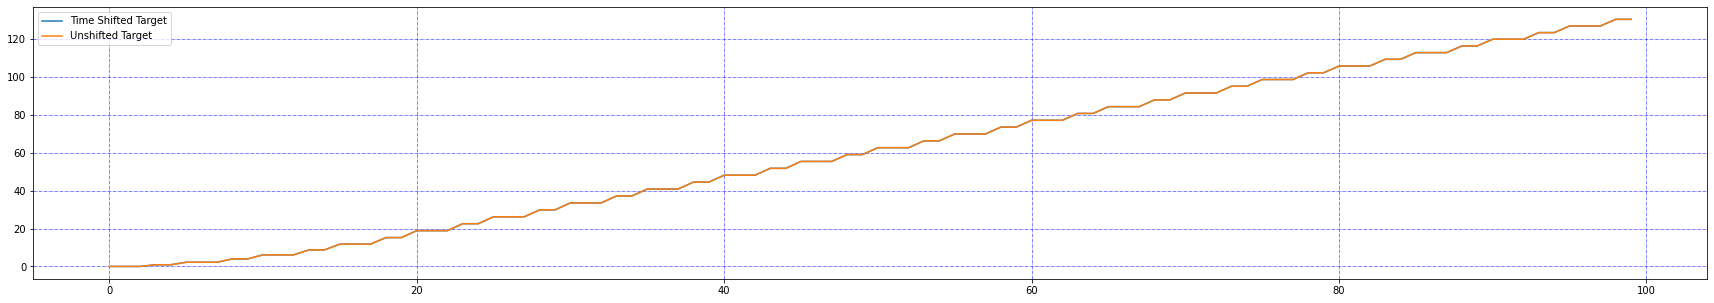

In [ ]:
signal_ = 0  # First signal from the 20 input-signals.
seq = x_train[:100, signal_].reshape(-1,1)
seq1 = myData[input_names].values[:100, signal_].reshape(-1,1)
plt.figure(figsize=(30,5))
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.plot(np.concatenate((seq, seq1), axis=1))
plt.legend(['Time Shifted Target','Unshifted Target', ])
# np.concatenate((seq,seq1), axis=1)

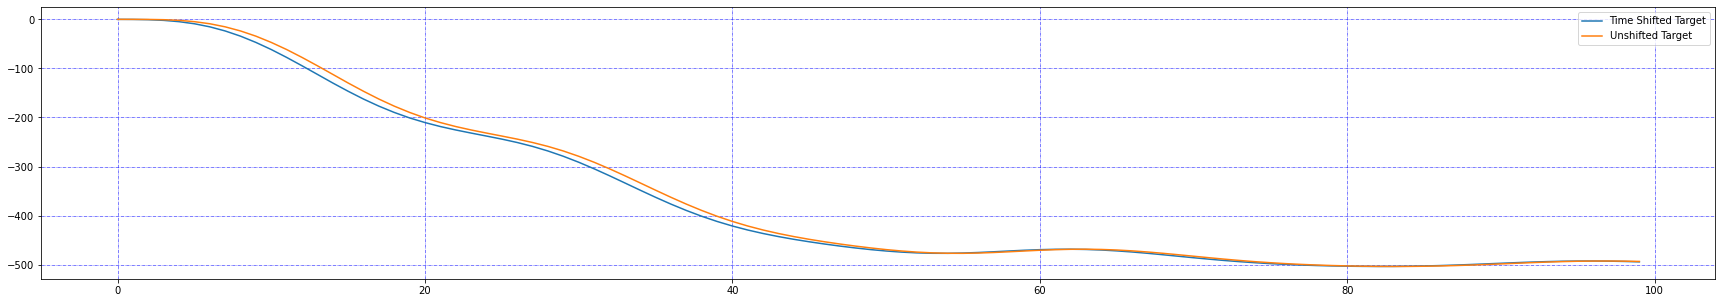

In [ ]:
signal_ = 0  # First signal from the 20 input-signals.
seq = y_train[:100, signal_].reshape(-1,1)
seq1 = myData[target_names].values[:100, signal_].reshape(-1,1)
plt.figure(figsize=(30,5))
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.plot(np.concatenate((seq, seq1), axis=1))
plt.legend(['Time Shifted Target','Unshifted Target', ])
# np.concatenate((seq,seq1), axis=1)

This is the number of observations in the training-set:

In [ ]:
num_train = x_train.size
num_train

2700000

This is the number of observations in the test-set:

In [ ]:
num_test = x_test.size
num_test

300000

These is the total number of input observations for the training and test sets:

In [ ]:
x_train.size + x_test.size

3000000

These is the total number of output observations for the training and test sets:

In [ ]:
y_train.size + y_test.size

6000000

This is the number of input features:

In [ ]:
num_x_signals = x_data.shape[1]
num_x_signals

6

This is the number of target features:

In [ ]:
num_y_signals = y_data.shape[1]
num_y_signals

12

### Check Data Magnitudes

The data-set contains a wide range of values:

In [ ]:
print('x_train min:', x_train.min())
print('x_train max:', x_train.max())

print('y_train min:', y_train.min())
print('y_train max:', y_train.max())

print('x_test min:', x_test.min())
print('x_test max:', x_test.max())

print('y_test min:', y_test.min())
print('y_test max:', y_test.max())

x_train min: tf.Tensor(-450.03, shape=(), dtype=float32)
x_train max: tf.Tensor(448.51, shape=(), dtype=float32)
y_train min: tf.Tensor(-2683.8, shape=(), dtype=float32)
y_train max: tf.Tensor(1232.9, shape=(), dtype=float32)
x_test min: tf.Tensor(-445.34, shape=(), dtype=float32)
x_test max: tf.Tensor(434.72, shape=(), dtype=float32)
y_test min: tf.Tensor(-2520.9, shape=(), dtype=float32)
y_test max: tf.Tensor(1145.7, shape=(), dtype=float32)


## Create Noise Generator

In [ ]:
class SNR_dB(tf.keras.metrics.Metric):
    def __init__(self, name="SNR_dB", **kwargs):
        super(SNR_dB, self).__init__(name=name, **kwargs)
        self.SNR = None
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_pred = tf.math.add(tf.math.abs(tf.keras.backend.min(y_pred, axis=-1, keepdims=True)), y_pred)
        # y_true = tf.math.add(tf.math.abs(tf.keras.backend.min(y_true, axis=-1, keepdims=True)), y_true)

        signal_power = tf.math.reduce_mean(tf.math.square(y_pred))
        noise_power = tf.math.reduce_mean(tf.math.square(tf.math.subtract(tf.math.abs(y_pred), tf.math.abs(y_true))))
        SNR_p = tf.math.divide_no_nan(tf.math.subtract(signal_power, noise_power), noise_power)
        SNR_p_DB = tf.math.multiply_no_nan(tf.experimental.numpy.log10(SNR_p), 10)
        self.SNR = SNR_p_DB
        return
        
    def result(self):
        return self.SNR

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.SNR = None
        return


In [ ]:
def white_noise(input_signal, SNR, dB=None):

    if dB:
        # print('Using dB')
        SNR_dB = SNR
        SNR_p = 10**tf.math.divide(SNR_dB,tf.constant(10.0, dtype=tf.float32))
        
    else:
        # print('Using SNR')
        SNR_p = SNR

    signal_power = tf.math.reduce_mean(tf.math.square(tf.math.abs(input_signal)))
    noise_power = tf.math.divide_no_nan(signal_power, tf.math.subtract(SNR_p, 1))
    return tf.experimental.numpy.random.randn(len(input_signal)) * tf.math.sqrt(noise_power)


def noisify_(input_data=None, SNR=None, dB=None, sampleRate=None, plot=False):
    n = len(input_data)
    period = n/sampleRate
    time = tf.experimental.numpy.linspace(0, period, n)
    signal_with_noise = np.zeros(tf.expand_dims(input_data, axis=0)[0].shape)
    signal_pure = input_data

    for i in range(input_data.shape[-1]):
        noise = white_noise(input_data[:,i], SNR, dB=dB)
        signal_with_noise[:,i] = signal_pure[:,i] + noise

        
        if plot:
            plt.figure(figsize=(30,5))   
            plt.plot(signal_pure[:,i])
            plt.title(input_names[i])
            plt.show()

            plt.figure(figsize=(30,5))   
            plt.plot(signal_with_noise[:,i])
            plt.title(input_names[i]+' + White Noise')
            plt.show()
            
            plt.figure(figsize=(30,5))
            # seaborn histogram with Kernel Density Estimation
            sns.histplot(white_noise(signal_pure[:,i], SNRdB, dB=dB), bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
            plt.title(input_names[i]+' White Noise Distribution')
            plt.show()
            
            rho=10
            f, psd = signal.periodogram(signal_with_noise[:,i], sampleRate)
            plt.figure(figsize=(30,5))
            plt.semilogy(f[1:], tf.math.sqrt(psd[1:]))
            plt.xlabel("frequency (Hz)")
            plt.ylabel(input_names[i] + " psd (arb.u./SQRT(Hz))")
            plt.axvline(13, ls="dashed", color="g")
            plt.axhline(rho, ls="dashed", color="r")
            plt.show()


    return signal_with_noise

# SNRdB = 20
# x_train_noised = noisify_(x_train[:500], SNR=SNRdB, dB=True, sampleRate=10000, plot=False)
# x_test_noised = noisify_(x_test[:500], SNR=SNRdB, dB=True, sampleRate=10000, plot=False)

# print('x_train_noised min:', x_train_noised.min())
# print('x_train_noised max:', x_train_noised.max())
# print('x_test_noised min:', x_test_noised.min())
# print('x_test_noised max:', x_test_noised.max())

## Check Train and Test Set Distribution


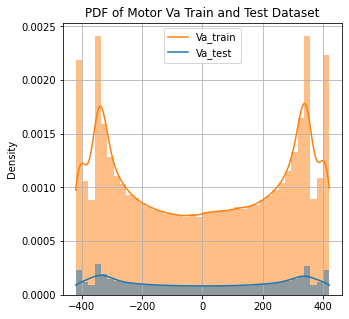

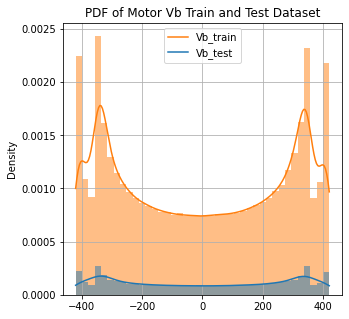

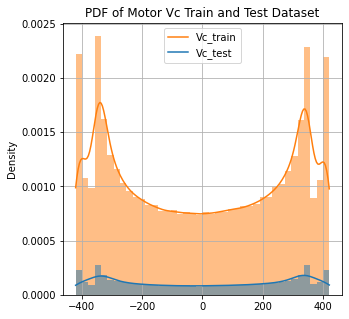

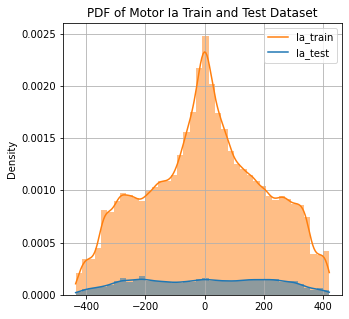

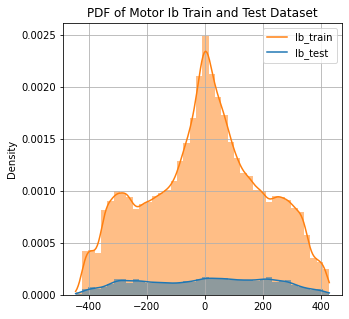

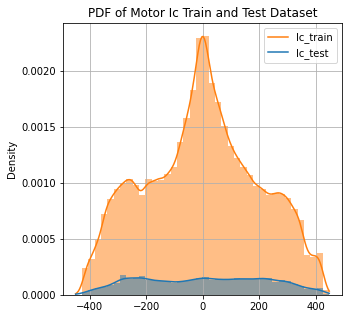

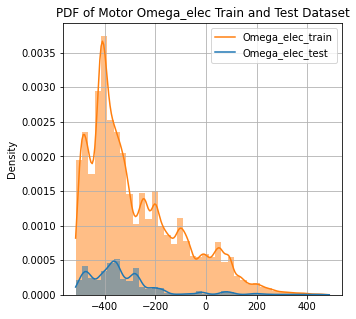

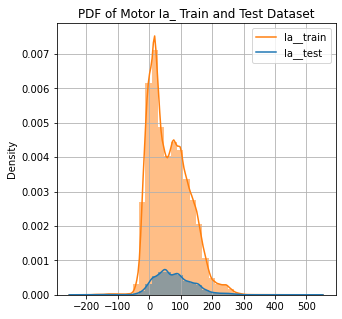

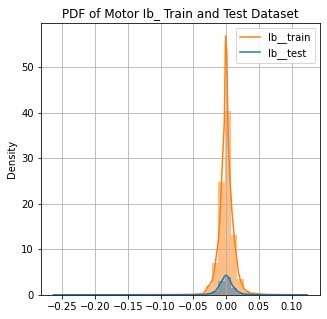

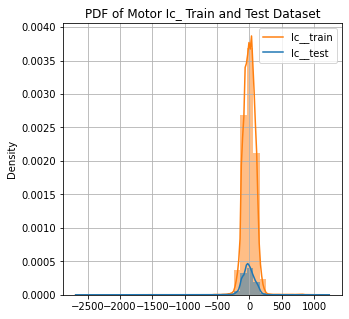

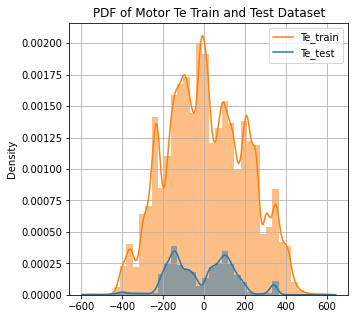

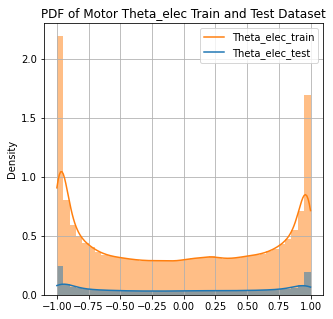

In [ ]:
for i in range(len(input_names)):
  plt.figure(figsize=(5,5))
  sns.histplot([x_test[:,i], x_train[:,i]], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
  plt.legend([f'{input_names[i]}_train', f'{input_names[i]}_test'])
  plt.title(f'PDF of Motor {input_names[i]} Train and Test Dataset')
  plt.grid()
  plt.show()
target_names = ['Omega_elec','Ia_','Ib_','Ic_','Te','Theta_elec']

for i in range(len(target_names)):
  plt.figure(figsize=(5,5))
  sns.histplot([y_test[:,i],y_train[:,i]], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
  plt.legend([f'{target_names[i]}_train', f'{target_names[i]}_test'])
  plt.title(f'PDF of Motor {target_names[i]} Train and Test Dataset')
  plt.grid()
  plt.show()
target_names = ['Omega_elec','Ia_','Ib_','Ic_','Te','cTheta_elec', 'sTheta_elec']


## Custom Tensorflow Data Generator 

The data-set has now been prepared as 2-dimensional numpy arrays. 

These are the array-shapes of the input and output data:

In [ ]:
# class CustomDataGen(tf.keras.utils.Sequence):
        
#     def __init__ (self, x_data, y_data, batch_size=None, sequence_length=None, train=True, fault=True, validation=True, SNR_dB=None, random_batch=True, random_SNR=False, random_idx=False):
        
#         self.x_train = x_data[0]
#         self.x_test = x_data[1]        
#         self.y_train = y_data[0]
#         self.y_test = y_data[1]
#         self.batch_size = batch_size
#         self.sequence_length = sequence_length
#         self.train = train
#         self.fualt = fault
#         self.validation = validation
#         self.SNR_dB = SNR_dB
#         self.random_batch = random_batch
#         self.random_SNR = random_SNR
#         self.random_idx = random_idx
#         self.n = int(self.x_train.shape[0])
    
#     def on_epoch_end(self):
#         #do nothing
#         return

#     def __getitem__(self, index):
#         if self.train:
#             # print('using train samples')
#             x_samples = self.x_train 
#             y_samples = self.y_train 
#             self.n = x_samples.shape[0]

#         elif self.validation:
#             # print('using validation samples')
#             x_samples = self.x_test[:num_val]
#             y_samples = self.y_test[:num_val]
#             self.n = x_samples.shape[0]
#         else:
#             # print('using test samples')
#             x_samples = self.x_test[-num_test:]
#             y_samples = self.y_test[-num_test:]
#             self.n = x_samples.shape[0]

#             # Allocate a new array for the batch of input-signals.
#         if self.train : #or self.validation
#             sequence_length_ = np.random.randint(1,self.sequence_length)
#         else:
#             sequence_length_ = self.sequence_length
#             # print(f"Sequence_length: {sequence_length_}")
        
#         if self.random_batch:
#             batch_size_ = np.random.randint(1,self.batch_size)
#         else: 
#             batch_size_ = batch_size
        
#         if self.random_SNR:
#             batchSNR = np.random.randint(5,self.SNR_dB)
#         else:
#             batchSNR = self.SNR_dB

#         x_shape = (batch_size_, self.sequence_length, x_samples.shape[1])
#         y_shape = (batch_size_, 1, y_samples.shape[1])
#         x_batch = np.zeros(shape=x_shape, dtype=np.float32)  
#         y_batch = np.zeros(shape=y_shape, dtype=np.float32) 
#         # y_batch = np.zeros(shape=x_shape, dtype=np.float32)  

            
#         # Fill the batch with random sequences of data.
#         for i in range(batch_size_):
#             # Get a random start-index.
#             idx = np.random.randint(self.n - sequence_length_)

#             if self.random_idx:
#                 sample_idx = np.random.randint(1,x_samples.shape[-1])
#             else:
#                 sample_idx = x_samples.shape[-1]

#             # This points somewhere into the training-data.
#             # x_batch[i] = noisify_(x_samples[idx:idx+sequence_length_].reshape(-1, x_samples.shape[-1]), SNR=batchSNR, dB=True, sampleRate=10000, plot=False)
           
#             x_batch[i:, :sequence_length_, :] = x_samples[idx:idx+sequence_length_].reshape(-1,x_samples.shape[-1]) 
            
#             # if self.fualt:
#             #     fault_idx = np.random.randint(3,6)
#             #     fault_idx = [fault_idx, fault_idx+3]
#             #     # print(f'Fault {fault_idx}, {input_names[fault_idx[0]]}, {input_names[fault_idx[1]]}')
#             #     x_batch[i:, :, fault_idx] = 0 
#             #     # print(f'Fault {x_batch[i:, :, fault_idx]}')
#             #     # print(f'Fault {x_batch[i:, :, fault_idx].shape}')

#             x_batch[i, :sequence_length_, :sample_idx] = noisify_(x_samples[idx:idx+sequence_length_,:sample_idx].reshape(-1,sample_idx), SNR=batchSNR, dB=True, sampleRate=10000, plot=False)
#             y_batch[i] = y_samples[idx+sequence_length_]  
#             # y_batch[i] = x_samples[idx:idx+sequence_length_].reshape(-1,x_samples.shape[-1])    
         
        
#         return x_batch, y_batch    
    
#     def __len__(self):
#         return int(self.n / self.batch_size)


# x_train_generator = CustomDataGen((x_train, x_test), (y_train, y_test), batch_size=batch_size, sequence_length=sequence_length, train=True, validation=False,  fault=False, SNR_dB=20, random_SNR=True, random_batch=False, random_idx=True)
# x_train_batch, y_train_batch=x_train_generator.__getitem__(1)

# print('x_train shape: ', x_train_batch.shape, 'x_train dtype:', x_train_batch.dtype)  
# print('y_train shape: ', y_train_batch.shape, 'y_train dtype:', y_train_batch.dtype)

# x_val_generator = CustomDataGen((x_train, x_test), (y_train, y_test), batch_size=batch_size, sequence_length=sequence_length, train=False, validation=True,  fault=False, SNR_dB=20, random_SNR=True, random_batch=False, random_idx=True)
# x_val_batch, y_val_batch=x_val_generator.__getitem__(1)

# print('x_val shape: ', x_val_batch.shape, 'x_val dtype:', x_val_batch.dtype)  
# print('y_val shape: ', y_val_batch.shape, 'y_val dtype:', y_val_batch.dtype)

# x_test_generator = CustomDataGen((x_train, x_test), (y_train, y_test), batch_size=batch_size, sequence_length=sequence_length, train=False, validation=False,  fault=False, SNR_dB=20, random_SNR=False, random_batch=False, random_idx=True)
# x_test_batch, y_test_batch=x_test_generator.__getitem__(1)

# print('x_test shape: ', x_test_batch.shape, 'x_test dtype:', x_test_batch.dtype)  
# print('y_test shape: ', y_test_batch.shape, 'y_test dtype:', y_test_batch.dtype)


# batch = 0   # First sequence in the batch.
# signal_ = 0  # First signal from the 20 input-signals.
# seq = x_train_batch[batch, :, signal_]
# plt.figure(figsize=(15,5))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.plot(seq)
# plt.legend(['Noisy Input Signal'])
# seq = y_train_batch[batch, :, signal_]
# plt.figure(figsize=(15,5))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.plot(seq)
# plt.legend(['Target Signal'])

# batch = 0   # First sequence in the batch.
# signal_ = 0  # First signal from the 20 input-signals.
# seq = x_val_batch[batch, :, signal_]
# plt.figure(figsize=(15,5))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.plot(seq)
# plt.legend(['Noisy Input Signal'])
# seq = y_val_batch[batch, :, signal_]
# plt.figure(figsize=(15,5))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.plot(seq)
# plt.legend(['Target Signal'])

# batch = 0   # First sequence in the batch.
# signal_ = 0  # First signal from the 20 input-signals.
# seq = x_test_batch[batch, :, signal_]
# plt.figure(figsize=(15,5))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.plot(seq)
# plt.legend(['Noisy Input Signal'])
# seq = y_test_batch[batch, :, signal_]
# plt.figure(figsize=(15,5))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.plot(seq)
# plt.legend(['Target Signal'])
  
# np.isnan(x_train_batch).any(), np.isnan(x_val_batch).any(), np.isnan(x_test_batch).any()

In [ ]:
# with tf.device('/device:GPU:0'):
output_types = (tf.float32, tf.float32)
output_shapes=((batch_size, sequence_length, num_x_signals), (batch_size, 1, num_y_signals))

class CustomDataGen:
        
    def __init__ (self, x_data, y_data, batch_size=None, sequence_length=None, train=True, fault=True, validation=True, SNR_dB=None, random_batch=True, random_SNR=False, random_idx=False):
        
        self.x_train = x_data[0]
        self.x_test = x_data[1]        
        self.y_train = y_data[0]
        self.y_test = y_data[1]
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.train = train
        self.fualt = fault
        self.validation = validation
        self.SNR_dB = SNR_dB
        self.random_batch = random_batch
        self.random_SNR = random_SNR
        self.random_idx = random_idx
        self.n = int(self.x_train.shape[0])
    
    def on_epoch_end(self):
        #do nothing
        return
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            

    def __getitem__(self, index):
        if self.train:
            # print('using train samples')
            x_samples = self.x_train 
            y_samples = self.y_train 
            self.n = x_samples.shape[0]

        elif self.validation:
            # print('using validation samples')
            x_samples = self.x_test[:num_val]
            y_samples = self.y_test[:num_val]
            self.n = x_samples.shape[0]
        else:
            # print('using test samples')
            x_samples = self.x_test[-num_test:]
            y_samples = self.y_test[-num_test:]
            self.n = x_samples.shape[0]

            # Allocate a new array for the batch of input-signals.
        if self.train : #or self.validation
            sequence_length_ = np.random.randint(1,self.sequence_length)
        else:
            sequence_length_ = self.sequence_length
            # print(f"Sequence_length: {sequence_length_}")
        
        if self.random_batch:
            batch_size_ = np.random.randint(1,self.batch_size)
        else: 
            batch_size_ = batch_size
        
        if self.random_SNR:
            batchSNR = np.random.randint(5,self.SNR_dB)
        else:
            batchSNR = self.SNR_dB

        x_shape = (batch_size_, self.sequence_length, x_samples.shape[1])
        y_shape = (batch_size_, 1, y_samples.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)  
        y_batch = np.zeros(shape=y_shape, dtype=np.float32) 
        # y_batch = np.zeros(shape=x_shape, dtype=np.float32)  

            
        # Fill the batch with random sequences of data.
        for i in range(batch_size_):
            # Get a random start-index.
            idx = np.random.randint(self.n - sequence_length_)

            if self.random_idx:
                sample_idx = np.random.randint(1,x_samples.shape[-1])
            else:
                sample_idx = x_samples.shape[-1]

            # This points somewhere into the training-data.
            # x_batch[i] = noisify_(x_samples[idx:idx+sequence_length_].reshape(-1, x_samples.shape[-1]), SNR=batchSNR, dB=True, sampleRate=10000, plot=False)
           
            x_batch[i:, :sequence_length_, :] = x_samples[idx:idx+sequence_length_].reshape(-1,x_samples.shape[-1]) 
            
            # if self.fualt:
            #     fault_idx = np.random.randint(3,6)
            #     fault_idx = [fault_idx, fault_idx+3]
            #     # print(f'Fault {fault_idx}, {input_names[fault_idx[0]]}, {input_names[fault_idx[1]]}')
            #     x_batch[i:, :, fault_idx] = 0 
            #     # print(f'Fault {x_batch[i:, :, fault_idx]}')
            #     # print(f'Fault {x_batch[i:, :, fault_idx].shape}')

            x_batch[i, :sequence_length_, :sample_idx] = noisify_(x_samples[idx:idx+sequence_length_,:sample_idx].reshape(-1,sample_idx), SNR=batchSNR, dB=True, sampleRate=10000, plot=False)
            y_batch[i] = y_samples[idx+sequence_length_]  
            # y_batch[i] = x_samples[idx:idx+sequence_length_].reshape(-1,x_samples.shape[-1])    
         
        
        return x_batch, y_batch    
    
    def __len__(self):
        return int(self.n / self.batch_size)


x_train_generator = CustomDataGen((x_train, x_test), (y_train, y_test), batch_size=batch_size, sequence_length=sequence_length, train=True, validation=False,  fault=False, SNR_dB=20, random_SNR=True, random_batch=False, random_idx=True)
train_dataset = tf.data.Dataset.from_generator(x_train_generator, output_types, output_shapes)
x_train_batch, y_train_batch=x_train_generator.__getitem__(1)

print('x_train shape: ', x_train_batch.shape, 'x_train dtype:', x_train_batch.dtype)  
print('y_train shape: ', y_train_batch.shape, 'y_train dtype:', y_train_batch.dtype)

x_val_generator = CustomDataGen((x_train, x_test), (y_train, y_test), batch_size=batch_size, sequence_length=sequence_length, train=False, validation=True,  fault=False, SNR_dB=20, random_SNR=True, random_batch=False, random_idx=True)
validation_dataset = tf.data.Dataset.from_generator(x_val_generator, output_types, output_shapes)
x_val_batch, y_val_batch=x_val_generator.__getitem__(1)

print('x_val shape: ', x_val_batch.shape, 'x_val dtype:', x_val_batch.dtype)  
print('y_val shape: ', y_val_batch.shape, 'y_val dtype:', y_val_batch.dtype)

x_test_generator = CustomDataGen((x_train, x_test), (y_train, y_test), batch_size=batch_size, sequence_length=sequence_length, train=False, validation=False,  fault=False, SNR_dB=20, random_SNR=False, random_batch=False, random_idx=True)
test_dataset = tf.data.Dataset.from_generator(x_test_generator, output_types, output_shapes)
x_test_batch, y_test_batch=x_test_generator.__getitem__(1)

print('x_test shape: ', x_test_batch.shape, 'x_test dtype:', x_test_batch.dtype)  
print('y_test shape: ', y_test_batch.shape, 'y_test dtype:', y_test_batch.dtype)


batch = 0   # First sequence in the batch.
signal_ = 0  # First signal from the 20 input-signals.
seq = x_train_batch[batch, :, signal_]
plt.figure(figsize=(15,5))
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.plot(seq)
plt.legend(['Noisy Input Signal'])
# seq = y_train_batch[batch, :, signal_]
# plt.figure(figsize=(15,5))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.plot(seq)
# plt.legend(['Target Signal'])

batch = 0   # First sequence in the batch.
signal_ = 0  # First signal from the 20 input-signals.
seq = x_val_batch[batch, :, signal_]
plt.figure(figsize=(15,5))
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.plot(seq)
plt.legend(['Noisy Input Signal'])
# seq = y_val_batch[batch, :, signal_]
# plt.figure(figsize=(15,5))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.plot(seq)
# plt.legend(['Target Signal'])

batch = 0   # First sequence in the batch.
signal_ = 0  # First signal from the 20 input-signals.
seq = x_test_batch[batch, :, signal_]
plt.figure(figsize=(15,5))
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.plot(seq)
plt.legend(['Noisy Input Signal'])
# seq = y_test_batch[batch, :, signal_]
# plt.figure(figsize=(15,5))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.plot(seq)
# plt.legend(['Target Signal'])
  
np.isnan(x_train_batch).any(), np.isnan(x_val_batch).any(), np.isnan(x_test_batch).any()


: 

: 

## Configure Hyperparameters

In [ ]:
dropout_rate = 0.5
input_shape = (sequence_length, num_x_signals)  # shape of the original input sequence to the model.
image_size = (sequence_length, num_x_signals)   # We'll resize input images to this size.
patch_size = (1, num_x_signals)                 # Size of the patches to be extract from the input images.
num_patches = sequence_length                   # Total number of patches t be fed to the network.
projection_dim = num_x_signals     # Dimension of the patch representation or embedding to be used (non-restrictive) in this case we are assuming that our embedding has the same dimensionality as our features which means we could technically sckip the embedding layer altogether.
num_heads = num_x_signals                    # Total number of differnt copies of Q K V matrices. These will be aggregated as you move from one layer to the next.
transformer_units = [projection_dim*num_y_signals, projection_dim]  # The left value accounts for receiving and concatenating the processed attention values and the original(or residual values) of the Multi-Attention head. The later value finally forces the input to have the actual expected output dimension.
transformer_layers = num_y_signals             # Total number of complete transformer blocks or layers to stack (non-restrictive). Mine computation, network size, GPU memory, speed, etc.
mlp_head_units = [num_y_signals*sequence_length, num_y_signals*sequence_length/2]       # This is your model output head (non-restrictive). Size and activation functions depend on task to be performed.


## Vison Transfomer - Image Patches
![Vison Transfomer - Image Patches](Vision_Transformer.png)


## Implement Patch Extraction Layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size

    # @tf.function( experimental_relax_shapes=True)
    def build(self, input_shape):
            self.built=True
            return

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size[0], self.patch_size[1], 1],
            strides=[1, self.patch_size[0], self.patch_size[1], 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1] * patches.shape[-2]
        # print(f"Patch dims: {patch_dims}")
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        # print(f"Patch shape: {patches.shape}")
        return patches

    # @tf.function( experimental_relax_shapes=True)
    def get_config(self):
        config = super().get_config().copy()
        config.update({'patch_size': self.patch_size})
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


Display Patches for Sample Image

image = np.expand_dims(x_train_batch[np.random.choice(range(x_train_batch.shape[0]))], axis=-1)
resized_image = tf.image.resize( tf.convert_to_tensor([image]), size=(image_size[0], image_size[1]))

patches = Patches(patch_size)(resized_image)

print(f"Image size: {image_size[0]} X {image_size[1]}")
print(f"Patches shape: {patches.shape}")
print(f"Patch size: {patch_size[0]} X {patch_size[1]}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

pd.DataFrame(patches[0], columns=input_names).plot(subplots=True, figsize=(15,10))  # Revisualize patches as signals

plt.figure(figsize=(5, 5*10))                                   # Explode image to patches
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(patches.shape[1], patches.shape[0], i + 1)
    # print('patch shape:', patch.shape)
    patch_img = tf.reshape(patch, (1, patch_size[1]))
    # print('patch_img shape:', patch_img.shape)
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

pd.DataFrame(patches[0], columns=input_names)   # Check if actual magnitudes of the signals have been lost


## Implement Ptch Encoding Layer

The `PatchEncoder` layer will linearly transforms a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.


In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches=sequence_length, projection_dim=num_x_signals, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)                                            # Project each input into a vector of fixed size using a trainable linear layer
        self.position_embedding = Embedding( input_dim=num_patches, output_dim=projection_dim )  # Create learnable embeding vectors of fixed size for all the inputs

    def build(self, input_shape):
        self.built=True
        return

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)            # Add positional information to fixed vector path projection by using left-right/top-bottom linear integer index of patches (100 timesteps in our case)
        encoded = self.projection(patch) + self.position_embedding(positions)  
        return encoded

    def get_config(self):
        config = super().get_config().copy()
        config.update({'num_patches': self.num_patches})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Implement Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [   
        Reshape(target_shape=(-1, num_x_signals, 1)),
        Resizing(image_size[0], image_size[1]),
        # RandomFlip("horizontal_and_vertical"),
        # RandomRotation(factor=0.02),
        # RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="Data_Augmentation_Layer",
)

## Implement A Custom Min-Max Scaling Layer

In [ ]:
with tf.device('/device:GPU:0'):
    class CustomScalingLayer(layers.Layer):
    
        def __init__(self, units=num_x_signals, **kwargs):
            super(CustomScalingLayer, self).__init__(**kwargs)
            self.units = units
        
        # @tf.function( experimental_relax_shapes=True)
        def build(self, input_shape):
            self.built=True
            return

        # @tf.function( experimental_relax_shapes=True) 
        def call(self, inputs):
            return tf.vectorized_map(lambda x: tf.math.divide_no_nan(tf.math.subtract(x, tf.keras.backend.min(x, axis=0, keepdims=False)) , tf.math.subtract(tf.keras.backend.max(x, axis=0, keepdims=False) , tf.keras.backend.min(x, axis=0, keepdims=False)))
, inputs)

        # @tf.function( experimental_relax_shapes=True)
        def get_config(self):
            config = super().get_config().copy()
            config.update({'units': self.units})
            return config

        @classmethod
        def from_config(cls, config):
            return cls(**config)

## Implement Custom MSE Loss Function

In [ ]:
with tf.device('/device:GPU:0'):
    @tf.function( experimental_relax_shapes=True)
    def loss_mse(y_true, y_pred):
        # Calculate the MSE loss for each value in these tensors.
        # This outputs a 3-rank tensor of the same shape.
        loss_vals = tf.keras.losses.mean_squared_error(y_true=y_true[:,:,:-3],
                                                        y_pred=y_pred[:,:,:-3])
        loss_theta = tf.keras.losses.mean_squared_error(y_true=tf.math.multiply_no_nan(y_true[:,:,-2:], 50, name=None),
                                                        y_pred=tf.math.multiply_no_nan(y_pred[:,:,-2:], 50, name=None))
        loss_torque = tf.keras.losses.mean_squared_error(y_true=tf.math.multiply_no_nan(y_true[:,:,4], 1, name=None),
                                                        y_pred=tf.math.multiply_no_nan(y_pred[:,:,4], 1, name=None))
        loss = tf.math.add(loss_vals, loss_theta)
        loss = tf.math.add(loss, loss_torque)
        
        # loss = tf.math.multiply_no_nan(loss, 1)
        # loss_mean = tf.reduce_mean(loss)

        loss_rmse = tf.math.sqrt(loss)

        return loss_rmse

## Implement Multilayer Perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation='gelu')(x)
        x = Dropout(dropout_rate)(x)
    return x


# Build and Compile the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.


Test other [activation functions](https://mlfromscratch.com/activation-functions-explained/#/)


In [ ]:

def create_vit_model():
    inputs = layers.Input(name='Input_Layer', shape=(sequence_length, num_x_signals))
    # Scale data.
    # scaled = CustomScalingLayer(name='MinMaxScaler', units=num_x_signals)(inputs)
    scaled = LayerNormalization(epsilon=1e-3, center=True, scale=True, axis=-1)(inputs)

    # Reshape data.
    reshaped = Reshape(target_shape=(-1, num_x_signals, 1))(scaled)
    
    # Resize data.
    resized = Resizing(image_size[0], image_size[1])(reshaped)

    # flipped  = RandomFlip("horizontal_and_vertical")(resized)

    # Create patches.
    patches = Patches(patch_size, name='Patch_Extraction')(resized)
    
    # Encode patches.
    encoded_patches = PatchEncoder(name='Patch_Encoding', num_patches=num_patches, projection_dim=projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-4, center=True, scale=True, axis=-1)(encoded_patches)                          # Normalize input 
        # print(f'x1 shape {x1.shape}') 
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)(x1, x1)
        # print(f'Attention Unit {i+1} Output shape {attention_output.shape}')                   # Don't undertand the (x1, x1) input
        
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])                                 # Elementwise addition of attention_output matrix and initial or processed/received matrix of original encoded_patches
        # print(f'x2 shape {x2.shape}') 

        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-4, center=True, scale=True, axis=-1)(x2)                                       # Normalize array
        # print(f'x3 shape {x3.shape}') 
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=dropout_rate)                         # Why not just a single layer having number of units equal to projection dimension?               
        # print(f'x3 MLP output shape {x3.shape}') 
        
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])                                               # Output of transformer block to be fed as an initial input to the next block or on to prediciton stage

    # Create a [batch_size, projection_dim] tensor.
    representation = LayerNormalization(epsilon=1e-4, center=True, scale=True, axis=-1)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(dropout_rate)(representation)
    # print(f'Transformer encoded representation shape {representation.shape}') 

    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=dropout_rate)
    
    # Predict outputs from featurs
    # initializer = tf.keras.initializers.LecunNormal()
    # Y_initializer = tf.keras.initializers.RandomNormal(mean=myData[target_names].describe()[1:3].values[0], stddev=myData[target_names].describe()[1:3].values[1].transpose())

    outputs = Dense(num_y_signals, activation='gelu')(features)
    outputs = Dense(num_y_signals, name='Output_Layer', activation='linear', use_bias=False)(outputs) #kernel_initializer=Y_initializer,

    outputs = Reshape(name='Reshape_Output', target_shape=(-1, num_y_signals))(outputs)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs, name='ViT_Observer_Model')

    # first_decay_steps = 500
    # lr_decayed_fn = (tf.keras.optimizers.schedules.CosineDecayRestarts(1e-5, first_decay_steps))
    # Create Optimizer.
    optimizer = Adam(learning_rate=1e-3, amsgrad=True)
    # moving_avg_Adam = tfa.optimizers.MovingAverage(optimizer)
    stocastic_avg_Adam = tfa.optimizers.SWA(optimizer)

    
    model.compile(loss='mse', optimizer=stocastic_avg_Adam, metrics=['mse', 'mae', 'mape', 'acc'], run_eagerly=True) 

    return model

ViT_model = create_vit_model()

ViT_model.summary()

Model: "ViT_Observer_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 100, 6)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 100, 6)      12          ['Input_Layer[0][0]']            
 alization)                                                                                       
                                                                                                  
 reshape_1 (Reshape)            (None, 100, 6, 1)    0           ['layer_normalization[0][0]']    
                                                                                                  
 resizing_1 (Resizing)          (None, 100, 6, 1)    0           ['reshape_1[0][0

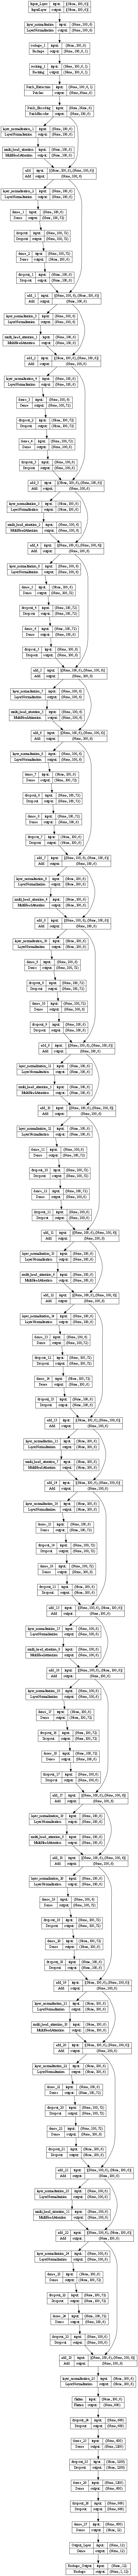

In [ ]:
plot_model(ViT_model, show_shapes=True, to_file='ViT_model.png', show_layer_names=True, rankdir='TB', expand_nested=True, dpi=50)

## Implement Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.
This is the callback for writing checkpoints during training.

In [ ]:
path_checkpoint = r'ViTModel.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=False,
                                      restore_best_weights=True,
                                      save_best_only=True)

In [ ]:
path_checkpoint_MA = r'ViTModel_avg_MA.h5'
path_checkpoint_SWA = r'ViTModel_avg_SWA.h5'

callback_MA = tfa.callbacks.AverageModelCheckpoint(filepath=path_checkpoint_MA, 
                                                    update_weights=True)

callback_SWA = tfa.callbacks.AverageModelCheckpoint(filepath=path_checkpoint_SWA, 
                                                    update_weights=True)



This is the callback for stopping the optimization when performance worsens on the validation-set.

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=400, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [ ]:
dirpaths = [Path('.\Tensorboard')]
for dirpath in dirpaths:
    if dirpath.exists() and dirpath.is_dir():
        try:        
            shutil.rmtree(dirpath, ignore_errors=True)
            os.chmod(dirpath, 0o777)
            os.rmdir(dirpath)
            os.removedirs(dirpath)
            print("Directory '%s' has been removed successfully", dirpath)
        except OSError as error:
            print(error)
            print("Directory '%s' can not be removed", dirpath)
            
callback_tensorboard = TensorBoard(log_dir=r'TensorBoard',
                                   histogram_freq=1,
                                   write_graph=True,
                                   profile_batch = '300,320')

[WinError 145] The directory is not empty: 'Tensorboard'
Directory '%s' can not be removed Tensorboard


import datetime

dirpath = Path('/content/drive/MyDrive/Transformers2022/Tensorboard')
 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callback_tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_graph=True, profile_batch = '500,520')                   
print(dirpath)


This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=10`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.95 gives a learning-rate of 9.5e-4. We don't want the learning-rate to go any lower 1e-5

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.99,
                                       min_lr=1e-7,
                                       patience=1,
                                       verbose=1)    

%reload_ext tensorboard

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             #callback_MA,
             #callback_clr,
             callback_SWA,
             callback_tensorboard,
             callback_reduce_lr]

#### Load weights from last checkpoint

In [ ]:
filepath = r'ViTModel.h5'
def train_model(resume, epochs, initial_epoch, batch_size, model):
    def fit_model():
        with tf.device('/device:GPU:0'):
            print(model.summary())
            history=model.fit(train_dataset, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=EPOCHS, 
                              verbose=1, 
                              callbacks=callbacks,
                              validation_data=validation_dataset, 
                              validation_steps=train_validation_steps, 
                              #validation_freq=5,
                              #class_weight=None, 
                              #max_queue_size=10, 
                              workers=32, 
                              use_multiprocessing=True,
                              #shuffle=True, 
                              initial_epoch=initial_epoch)
            model.load_weights(path_checkpoint)            
            model.save(filepath)
            model.evaluate(x_test_generator, steps=test_validation_steps)
        
            return history
    
    if resume:
        try:
            #del model
            model = load_model(filepath, custom_objects = {"Patches": Patches, "PatchEncoder": PatchEncoder, "CustomScalingLayer": CustomScalingLayer, "loss_mse": loss_mse})
            # model.load_weights(path_checkpoint)
            print(model.summary())
            print("Model loading....")
            model.evaluate(x_test_generator, steps=test_validation_steps)
            
        except Exception as error:
            print("Error trying to load checkpoint.")
            print(error)
        
    # Training the Model
    return fit_model()
    
with tf.device('/device:GPU:0'):
    def plot_train_history(history, title):
        loss = history.history['loss']
        accuracy = history.history['acc']
        mape = history.history['mape']
        mae = history.history['mae']
        val_loss = history.history['val_loss']
        val_accuracy = history.history['val_acc']
        val_mae = history.history['val_mae']
        val_mape = history.history['val_mape']
        epochs = range(len(loss))
        plt.figure(figsize=(30,5))
        plt.plot(epochs, loss, label='training_loss') 
        plt.plot(epochs, val_loss, label='validation_loss')
        plt.show()
        plt.figure(figsize=(30,5))
        plt.plot(epochs, accuracy, label='training_accuracy') 
        plt.plot(epochs, val_accuracy, label='validation_accuracy')
        plt.show()
        plt.figure(figsize=(30,5))
        plt.plot(epochs, mae, label='training_mae') 
        plt.plot(epochs, val_mae, label='validation_mae')
        plt.show()
        plt.figure(figsize=(30,5))
        plt.plot(epochs, mape, label='training_mape') 
        plt.plot(epochs, val_mape, label='validation_mape')
        plt.show()
        return



#call tensorboard
!pip install -U tensorboard-plugin-profile

%tensorboard --logdir logs

## Train Model

In [ ]:
EPOCHS = 1000000

# steps_per_epoch = int((num_train/batch_size))
steps_per_epoch = int(1000)

for _ in range(1):
  try:
    # ViT_model = load_model(r'ViTModel_avg_65.h5', {"Patches": Patches, "PatchEncoder": PatchEncoder, "CustomScalingLayer": CustomScalingLayer, "loss_mse": loss_mse})
    # ViT_model.load_weights(r'ViTModel_avg_65.h5', {"Patches": Patches, "PatchEncoder": PatchEncoder, "CustomScalingLayer": CustomScalingLayer, "loss_mse": loss_mse})
    ViT_model.save(r'ViTModel.h5')
    ViT_model = load_model(r'ViTModel.h5', {"Patches": Patches, "PatchEncoder": PatchEncoder, "CustomScalingLayer": CustomScalingLayer, "loss_mse": loss_mse})
    print("Checkpoint Loaded")  
  except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
    
# Train model
with tf.device('/device:GPU:0'):
    history = train_model(resume=False, epochs=EPOCHS, initial_epoch=0, batch_size=batch_size, model=ViT_model)
    # plot_train_history(history, 'Model Training History')
    ViT_model.history


Checkpoint Loaded
Model: "ViT_Observer_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 100, 6)]     0           []                               
                                                                                                  
 layer_normalization_90 (LayerN  (None, 100, 6)      12          ['Input_Layer[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 reshape_13 (Reshape)           (None, 100, 6, 1)    0           ['layer_normalization_90[0][0]'] 
                                                                                                  
 resizing_13 (Resizing)         (None, 100, 6, 1)    0         

KeyboardInterrupt: 

In [ ]:
# from pynput.mouse import Button, Controller
# import time

# mouse = Controller()

# while True:
#     mouse.click(Button.left, 1)
#     time.sleep(30)

%tensorboard --logdir /content/drive/MyDrive/Transformers2022/Tensorboard/

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [ ]:
with tf.device('/device:GPU:0'):
    try:
        ViT_model = load_model(r'ViTModel.h5', {"Patches": Patches, "PatchEncoder": PatchEncoder})
        ViT_model.load_weights(r'ViTModel.h5', {"Patches": Patches, "PatchEncoder": PatchEncoder})
        print("Checkpoint Loaded")
    except Exception as error:
        print("Error trying to load checkpoint.")
        print(error)

Error trying to load checkpoint.
Unknown layer: CustomScalingLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [ ]:
with tf.device('/device:GPU:0'):
    ViT_model.evaluate(x_train_generator, steps=train_validation_steps)
    ViT_model.evaluate(x_val_generator, steps=train_validation_steps)
    ViT_model.evaluate(x_test_generator, steps=test_validation_steps)

1/1 [==============================] - 0s 90ms/step - loss: 17824.6172 - mse: 17824.6172 - mae: 73.5809 - mape: 133.6742 - acc: 0.5938


In [ ]:
warmup_steps=0
start_idx = 249500 + 250
test_length = 500
rho = 0.05
sr = 10000

with tf.device('/device:GPU:0'):
        mape = tf.keras.losses.MeanAbsolutePercentageError()
        mae = tf.keras.losses.MeanAbsoluteError()
        target_names = ['Omega_elec','Ia_','Ib_','Ic_','Te', 'cTheta_elec', 'sTheta_elec', 'Theta_elec']
        sequence_length=100

        x_true = np.zeros(shape=(test_length,num_x_signals))
        y_pred = np.zeros(shape=(test_length,num_y_signals))
        y_true = np.zeros(shape=(test_length,num_y_signals))
        angle_true = np.zeros(shape=(test_length,1))
        angle_pred = np.zeros(shape=(test_length,1))


        for i in tqdm_notebook(range(start_idx,start_idx+test_length), desc='Loop 1'):
                x = x_test[i:i+sequence_length].reshape(1,sequence_length,-1).reshape(1,sequence_length,-1)
                x = noisify_(x.reshape(-1,x.shape[-1]), SNR=30, dB=True, sampleRate=10000, plot=False).reshape(1,-1,x.shape[-1])
                y_true[i-start_idx] = y_test[i+sequence_length].reshape(1,-1)
                y_pred[i-start_idx] = ViT_model.predict(x)

        x_true = x_test[start_idx:start_idx+test_length]
        x_noisy = noisify_(x_test[start_idx:start_idx+test_length].reshape(-1,x_test[start_idx:start_idx+test_length].shape[-1]), SNR=30, dB=True, sampleRate=10000, plot=False)

        y_true = y_scaler.inverse_transform(y_true[:,:])   
        y_pred = y_scaler.inverse_transform(y_pred[:,:])

        for i in range(len(angle_true)):
                angle_true[i] = np.arctan2(y_true[i,-1],y_true[i,num_y_signals-2])*2*np.pi
                angle_pred[i] = np.arctan2(y_pred[i,-1],y_pred[i,num_y_signals-2])*2*np.pi

        y_true = np.concatenate([y_true,angle_true], axis=1)
        y_pred = np.concatenate([y_pred,angle_pred], axis=1)

Loop 1:   0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
tfp.stats.correlation(y_true, y=y_pred, sample_axis=0, event_axis=-1, keepdims=False, name=None)


In [ ]:

# for signal_ in range(len(input_names)):
               
#         # Get the true output-signal from the data-set.
#         signal_true = x_true[:, signal_]
#         signal_noisy = x_noisy[:, signal_]

#         # Make the plotting-canvas bigger.
#         plt.figure(figsize=(35,5))
        
#         # Plot and compare the two signals.
#         plt.plot(signal_true, label='true')
#         plt.plot(signal_noisy, label='noisy')
   
        
#         # Plot grey box for warmup-period.
#         p = plt.axvspan(400, 600, facecolor='black', alpha=0.15)
        
#         # Plot labels etc.
#         plt.ylabel(input_names[signal_])
#         plt.grid(color='b', linestyle='-.', linewidth=0.5)
#         plt.legend()
#         plt.show()


for signal_ in tqdm_notebook(range(len(target_names)), desc='Loop 1'):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred[:, signal_]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal_]
        
        error = np.zeros(len(signal_true))
        p_error = np.zeros(len(signal_true))
        a_error = np.zeros(len(signal_true))

        for i in range(len(signal_true)):
            error[i] = signal_true[i]-signal_pred[i]
            p_error[i] = np.clip(mape((signal_true[i]+max(signal_true)).reshape(-1,1), (signal_pred[i]+max(signal_true)).reshape(-1,1)), 0, 100)
            a_error[i] = mae((signal_true[i]+max(signal_true)).reshape(-1,1), (signal_pred[i]+max(signal_true)).reshape(-1,1))
        mae_ =  mae(signal_true, signal_pred)
        mape_ =  np.clip( mape(signal_true, signal_pred), 0, 100)

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(10,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label=f'{target_names[signal_]}_true')
        plt.plot(signal_pred, label=f'{target_names[signal_]}_pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(400-250, 600-250, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal_])
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()
        
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(10,5))
        
        # Plot and compare the two signals.
        plt.plot(error, label=f'{target_names[signal_]}_Error')
        plt.plot(a_error, label=f'Absolute Error, MAE:{np.round(mae_)}')        

                
        # Plot grey box for warmup-period.
        p = plt.axvspan(400-250, 600-250, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal_])
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(10,5))
        
        # Plot and compare the two signals.
        plt.plot(p_error, label=f'Percentage Error MAPE:{np.round(mape_)}')        
                
        # Plot grey box for warmup-period.
        p = plt.axvspan(400-250, 600-250, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal_])
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(10,5))
        
        # Plot and compare the two signals.
        plt.scatter(signal_true, signal_pred)

        # Plot labels etc.
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.xlabel(f'{target_names[signal_]}_true')
        plt.ylabel(f'{target_names[signal_]}_pred')
        plt.show()